In [2]:
import pandas as pd
df=pd.read_csv('/content/drive/MyDrive/combined_trajectories.csv',nrows=700000)
df.tail()

,latitude,longitude,altitude,date,time,individual_id,trajectory_id
699995,39.990486,116.327432,233.0,2009-01-13,04:41:14,4,104
699996,39.990493,116.327446,258.0,2009-01-13,04:41:19,4,104
699997,39.990520,116.327503,281.0,2009-01-13,04:41:24,4,104
699998,39.990574,116.327600,297.0,2009-01-13,04:41:29,4,104
699999,39.990623,116.327716,309.0,2009-01-13,04:41:34,4,104


In [5]:
import numpy as np
from multiprocessing import Pool, cpu_count
def group_by_user(df):
    """
    Group dataframe by user_id
    """
    return df.groupby('individual_id')

def create_user_trajectories(user_df):
    """
    Create list of trajectory dataframes for a given user dataframe
    """
    trajectories = []
    for _, traj_df in user_df.groupby('individual_id'):
        
        trajectories.append(traj_df)
        
    # print(trajectories[0])
    return trajectories

import math
def haversine_distance(lon1, lat1, lon2, lat2,  alt1,alt2):
    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])

    # calculate haversine distance
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.asin(math.sqrt(a))


    dalt = alt2 - alt1

    dist_3d = math.sqrt(c**2 + dalt**2)

    return dist_3d

def calculate_user_distance(trajectories):
    """
    Calculate total distance traveled by a given user
    """
    total_distance = 0
    for traj_df in trajectories:
        # calculate distance for each pair of consecutive points in trajectory
        for i in range(1, len(traj_df)):
            lon1, lat1, alt1 = traj_df.iloc[i-1][['longitude', 'latitude' ,'altitude']]
            lon2, lat2 , alt2 = traj_df.iloc[i][['longitude', 'latitude' , 'altitude']]
            distance = haversine_distance(lon1, lat1, lon2, lat2 , alt1,alt2)
            total_distance += distance
    return total_distance

def calculate_total_distance(df):
    """
    Calculate total distance traveled by each user in the dataset using multiprocessing
    """
    # group dataframe by user_id
    user_groups = group_by_user(df)

    # create list of trajectory dataframes for each user
    user_trajectories = [create_user_trajectories(user_df) for _, user_df in user_groups]

 # create multiprocessing pool with number of processes equal to number of CPU cores
    pool = Pool(processes=cpu_count())

    # # apply calculate_user_distance function to each user dataframe in parallel
    total_distances = pool.map(calculate_user_distance, user_trajectories)
    print(total_distances)
    # # combine user_ids and total_distances into pandas dataframe
    result = pd.DataFrame({'user_id': [user_id for user_id, _ in user_groups],
                           'total_distance': total_distances})

    return result

In [6]:
# distance of individual by individual 
# brute force 
calculate_total_distance(df)

--------------
________________________________________________
[1194694.0390591281, 497596.02137196605, 1504176.1342267706, 1175265.0305609414]


,user_id,total_distance
0,1,1.194694e+06
1,2,4.975960e+05
2,3,1.504176e+06
3,4,1.175265e+06


In [8]:
! pip install geopandas


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 86.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 86.4 MB/s eta 0:00:00


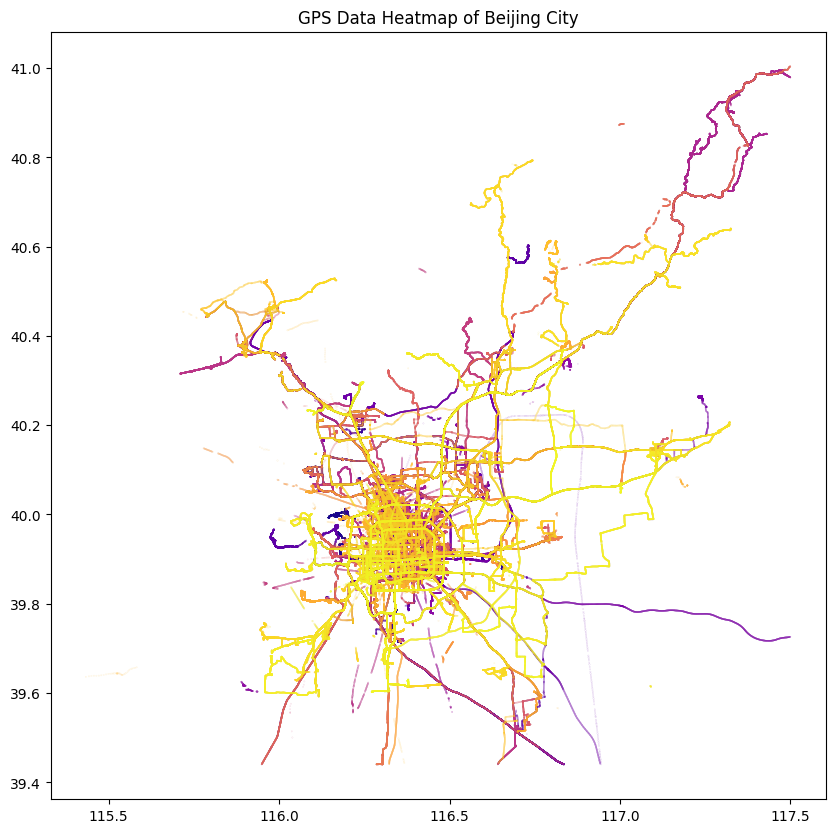

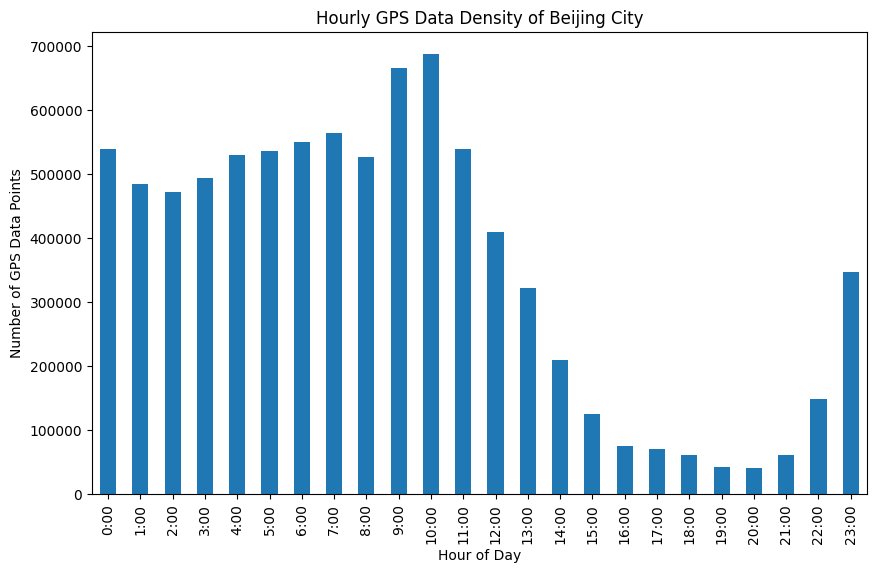

In [19]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

# Load the GPS data
gps_data = df

# Filter the GPS data to only contain trips within Beijing City
beijing_bbox = [115.42, 39.44, 117.50, 41.06]  # longitude and latitude coordinates of Beijing City
gps_data = gps_data[(gps_data['longitude'] >= beijing_bbox[0]) & (gps_data['longitude'] <= beijing_bbox[2])
                    & (gps_data['latitude'] >= beijing_bbox[1]) & (gps_data['latitude'] <= beijing_bbox[3])]

# Convert the GPS data to a GeoDataFrame
geometry = [Point(xy) for xy in zip(gps_data['longitude'], gps_data['latitude'])]
crs = 'EPSG:4326'
gps_gdf = gpd.GeoDataFrame(gps_data, crs=crs, geometry=geometry)

# Spatial hotspot visualization: Heatmap
fig, ax = plt.subplots(figsize=(10, 10))
gps_gdf.plot(ax=ax, markersize=0.01, alpha=0.5, column=None, cmap='plasma')
ax.set_title('GPS Data Heatmap of Beijing City')
plt.show()

# Temporal hotspot visualization: Hourly Density
gps_gdf['time'] = pd.to_datetime(gps_gdf['time'])
gps_gdf['hour'] = gps_gdf['time'].dt.hour
hourly_density = gps_gdf.groupby(['hour']).size().reset_index(name='count')
hourly_density.plot(kind='bar', x='hour', y='count', legend=None, figsize=(10, 6))
plt.title('Hourly GPS Data Density of Beijing City')
plt.xlabel('Hour of Day')
plt.ylabel('Number of GPS Data Points')
plt.xticks(hourly_density['hour'], [f"{i}:00" for i in hourly_density['hour']])
plt.show()
